# CENG796 - Project Submission

This notebook is about our implementation of ["A U-Net Based Discriminator for Generative Adversarial Networks"](https://arxiv.org/abs/2002.12655). (CVPR2020)

All figures and tables in this notebook are from the original paper unless stated otherwise.

### Project Members
Çağrı Eser, 2171593, cagri.eser@metu.edu.tr

Yaşar Cahit Yıldırım, 2310647, cahit.yildirim@metu.edu.tr

## A U-Net Based Discriminator for Generative Adversarial Networks

###  Paper Abstract

Among the major remaining challenges for generativeadversarial networks (GANs) is the capacity to synthesize globally and locally coherent images with object shapes and textures indistinguishable from real images. To target this issue we propose an alternative U-Net based discriminator architecture, borrowing the insights from the segmentation literature. The proposed U-Net based architecture allows to provide detailed per-pixel feedback to the generator while maintaining the global coherence of synthesized images, by providing the global image feedback as well. Empowered by the per-pixel response of the discriminator, we further propose a per-pixel consistency regularization technique based on the CutMix data augmentation, encouraging the U-Net discriminator to focus more on semantic and structural changes between real and fake images.  This improves the U-Net discriminator training, further enhancing the quality of generated samples. The novel discriminator improves over the state of the art in terms of the standard distribution and image quality metrics, enabling the generator to synthesize images with varying structure, appearance and levels of detail, maintaining global and local realism. Compared to the BigGAN baseline, we achieve an average improvement of 2.7 FID points across FFHQ, CelebA, and the newly introduced COCO-Animals dataset.

### Standard GAN Model

A ”vanilla” GAN consists of two networks:  a generator $G$ and a discriminator $D$, trained by minimizing the following competing objectives in an alternating manner:

$$ L_{D} = -E_{x}[logD(x)] - E_{z}[log(1 - D(G(z)))] $$
$$ L_{G} = -E_{z}[logD(G(z))] $$

Note that the $L_{G}$ loss is proposed as non-saturating GAN.
Ordinarily, $G$ and $D$ are modeled as a decoder and an encoder convolutional network, respectively.

### U-Net GAN Model

The authors propose to alter the $D$ architecture from a standard classification network to an encoder-decoder U-Net network. This new $D^{U}$ discriminator is able to make normal image classification at its encoder network $D^{U}_{enc}$, and it also outputs a per-pixel classification label through its decoder network $D^{U}_{dec}$. The generator network is not modified in any major contribution of the paper (BigGAN's generator for 128x128 is taken with minimal modifications). Overall, the U-Net GAN has the following design (Figure 2 in the original paper):

![model](./resources/ugan.png)

### U-Net GAN Losses

The U-Net GAN discriminator is designed as a U-Net $D^{U}$, where an encoder network $D^{U}_{enc}$ and decoder network $D^{U}_{dec}$ are connected via a bottleneck, as well as skip connections that copy and concatenate feature maps from the encoder to the decoder network.

The encoder network classifies the input image as real or fake, and the decoder network performs this classification on a per-pixel basis. The overall decoder loss in this then equal to
$$ L_{D^{U}} = L_{D^{U}_{enc}} + L_{D^{U}_{dec}} $$

where we have the encoder loss as 
$$ L_{D^{U}_{enc}} = -E_{x}[logD^{U}_{enc}(x)] - E_{z}[log(1 - D^{U}_{enc}(G(z)))] $$
and the decoder loss as the mean classification over all pixels:
$$ D^{U}_{dec} = -E_{x}[\sum_{i, j}log[D^{U}_{dec}(x)]_{i, j}] - E_{z}[\sum_{i, j}log(1 - [D^{U}_{dec}(G(z))]_{i,j})] $$

Correspondingly, the generator loss becomes:
$$ L_{G} = -E_{z}[logD^{U}_{enc}(G(z)) + \sum_{i, j}log[D^{U}_{dec}(G(z))]_{i, j}] $$

### Consistency Regularization

The authors propose consistancy regularization of the $D^{U}$ discriminator by encouraging the decoder module $D^{U}_{dec}$ to output preditions under CutMix transformations of real and fake samples.

CutMix augmentation creates synthetic images via cutting and pasting patches from real images and generated synthetic images. In short, a mix ratio $r$ is sampled from $U[0, 1]$, and a mask is obtained by cutting out a patch of a real image and replacing it with another image, thereby maintaining the area ratio $r$. These samples are visualized below (Figure 3 in the original paper):

![cutmix](./resources/cutmix.png)

New training samples $\hat{x}$ are synthesized by mixing real sample $x$ and generated $G(z)$ with a sampled CutMix mask $M$:

$$ \hat{x} = mix(x, G(z), M) $$
$$ mix(x, G(z), M) = M \odot x + (1 - M) \odot G(z) $$

The mask $M$ is a binary mask indicating if a pixel is from the original image $M_{i, j} = 1$ or from the fake iamge $M_{i, j} = 0$.

When computing loss, CutMix images are treated differently:
For $D^{U}_{enc}$, CutMix images are labeled as fake ($c = 0$).
For $D^{U}_{dec}$, CutMix image classification ground truth labels are the mask $M$ itself.

Following these, the authors introduce the consistency regularization loss term for the discriminator:
$$ L^{cons}_{D^{U}_{dec}} = || D^{U}_{dec}(mix(x, G(z), M)) - mix(D^{U}_{dec}(x), D^{U}_{dec}(G(z)), M)||^{2}$$

This loss is then added to the overall discriminator loss:

$$ L_{D^{U}} = L_{D^{U}_{enc}} + L_{D^{U}_{dec}} + \lambda L^{cons}_{D^{U}_{dec}} $$
where the authors find $\lambda = 1$ to be a good hyperparameter. The generator objective does not change under consistency regularization loss.

### Relevant experiments

We focus our attention on the FID results (Section 4.2 - Table 3) reported on the CelebA dataset with cropped 128x128 image resolution.

| Method    | FID  | IS   |
|-----------|------|------|
| U-Net GAN | 2.95 | 3.43 |

Alternatively, the authors also report FID calculated via the PyTorch implementation (on Appendix A - Table S1)

| Method    | FID  | IS   |
|-----------|------|------|
| U-Net GAN | 2.03 | 3.33 |

## Experiments

The [experiments](./experiments) directory contains incremental implementations of each part of the paper, such as CutMix training, U-NetGAN discriminator loss, and scaling to 128x128 image sizes.

See [experiments/README](./experiments/README.md) if interested in intermediate results.

The cells below show the results obtained with the final trained network (assumed to be under `resources/trained.pth`, see README.md for a download link. Trained for ~32.5k iterations).

Generator and Discriminator loss graphs, screenshot from tensorboard.

<img src="./resources/gen.png" alt="generator" width="400"/>

<img src="./resources/disc.png" alt="discriminator" width="400"/>

In [1]:
import torch
import random
import numpy as np
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline 

from unetgan import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_generators(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
seed_generators(796)

In [3]:
trained_dis = BigGANDiscriminator().to(device)
trained_gen = BigGANGenerator(latent_dim=140, base_ch_width=64).to(device)

utils.load_pretrained_models(trained_dis, trained_gen, './resources/trained.pth')

<All keys matched successfully>
<All keys matched successfully>


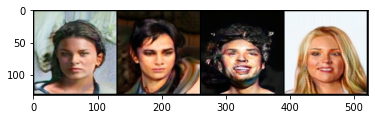

In [4]:
noise = torch.randn((4, 140), device=device)
sample = trained_gen(noise)
preview_samples(plt, sample, figure_size=(16,2))

## Quantitative evaluation

Let's compute FID scores. To do this, we need to create a "fake" dataset and compare its statistics with an equivalent "real" dataset. So let's generate a "fake" dataset of 10k images using the trained generator (10k is the suggested minimum as a rule of thumb for FID)

In [5]:
# Create our "fake" dataset for FID stats
utils.create_sample_directory(trained_gen, sample_dir='./celeba_fake_samples',
                              num_samples=10000, device=device, overwrite=True)

100%|██████████| 10000/10000 [02:42<00:00, 61.38it/s]


We should also create a subset of the real dataset which has the same characteristics (cropped size, centering, etc.):

In [6]:
# Create the target "real" dataset
utils.create_celeba_sample_directory(celeba_root_dir='.',
                                     sample_dir='./celeba_real_samples',
                                     num_samples=10000,
                                     overwrite=True)

100%|██████████| 10000/10000 [01:09<00:00, 143.21it/s]


We can now compute FID scores using these. Let's use the official PyTorch and TensorFlow implementations of FID (you will need to install `pytorch_fid` using `pip` or clone `TTUR` from GitHub to execute the cells below):

In [7]:
!python -m pytorch_fid ./celeba_fake_samples ./celeba_real_samples

100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.51it/s]
FID:  20.162227883912692


In [8]:
!TTUR/fid.py ./celeba_fake_samples ./celeba_real_samples

2021-07-06 22:36:04.852970: W tensorflow/core/framework/op_def_util.cc:357] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

2021-07-06 22:36:04.968418: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-06 22:36:04.999025: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2021-07-06 22:36:04.999656: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c9506e85f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-06 22:36:04.999730: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info 

Our results are somewhat close to the officially reported FID values on CelebA, and maybe the difference in values can be attributed to the difference in training time (32k vs 800k).

### Challenges Encountered

The main challenge that we've encountered is that for the reported FID scores and generated images, the authors train the proposed U-NetGAN (with BigGAN-like discriinator and generator) model for 800.000 iterations using a batch size of 50 given 128x128 resolution images. For us, it has been difficult to allocate computational resources to train and evaluate this model (We couldn't even fit the model + suggested batch size of images into a single GPU with 7GB of memory during training).

For this reason, we had to start by using "lower-budget models" in our experiments to observe the contributions of the paper. In essence, the "U-Net GAN loss" does not require the original full-fledged GAN in the paper to be used, so we used a lesser model (relying on "good old DCGAN") to implement "U-Net GAN loss", per-pixel classification, consistancy loss and evaluation scores while preparing the main model.

After we used these "training wheels" to verify the parts of the model, we started to train the full model. With our effort, we could only train the model for 100k iterations, which we used to report statistics in the Experiments section. The actual results in FID don't seem too bad (`2.03` vs `20.30`), and the qualitative results look "realistic enough" despite the difference in training.

There was also some confusion on how to evaluate our models, as the original FID score reported in the paper is based on the TensorFlow Inceptionv3 model, and the FID scores are not the same when we use PyTorch. In the end, we decided that we can use both versions to output FID scores, since the authors also provide the PyTorch FID score as well.